## Prep traj outputs from stream

In [10]:
# Removes CPU usage limit by some jupyter versions
import os
os.environ['KMP_AFFINITY'] = ''
# Configure matplotlib to enable large animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt
import pandas as pd
import dictys

# path to stream outputs
stream_outs = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/all_ntc"
dictys_data_path = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/dictys/rbpj_ets1_ikzf1_ntc/data"

In [11]:
# Load data
dist = pd.read_csv(os.path.join(stream_outs, 'dist.tsv.gz'), header=0, index_col=0, sep='\t')
edge = pd.read_csv(os.path.join(stream_outs, 'edge.tsv.gz'), header=None, index_col=None, sep='\t')
branch = pd.read_csv(os.path.join(stream_outs, 'branch.tsv.gz'), header=None, index_col=None, sep='\t')

# Display the first few rows of each DataFrame to confirm successful loading
print("dist DataFrame:")
display(dist.head())
print("dist DataFrame shape:", dist.shape)

print("edge DataFrame:")
display(edge.head())
print("edge DataFrame shape:", edge.shape)

print("branch DataFrame:")
display(branch.head())
print("branch DataFrame shape:", branch.shape)

dist DataFrame:


,S0,S1
S4_AAACCCAAGCACGATG-1-0,0.000543,0.004328
S4_AAACCCAGTGAATAAC-1-0,0.004132,0.000739
S4_AAACCCAGTGGAGGTT-1-0,0.004295,0.000576
S4_AAACGAAGTGAGGAAA-1-0,0.004308,0.000563
S4_AAACGAAGTGTAACGG-1-0,0.003978,0.000893


dist DataFrame shape: (14196, 2)
edge DataFrame:


,0,1
0,0,1


edge DataFrame shape: (1, 2)
branch DataFrame:


,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


branch DataFrame shape: (14196, 2)


In [12]:
# Save data
traj = dictys.traj.trajectory.fromdist(edge.values, dist.values)
traj_file_path = os.path.join(dictys_data_path, 'traj_node.h5')
traj.to_file(traj_file_path)

point = dictys.traj.point.fromdist(traj, branch.values, dist.values)
point_file_path = os.path.join(dictys_data_path, 'traj_cell_rna.h5')
point.to_file(point_file_path, traj=False)

In [13]:
# inspect the output .h5 files
import h5py
traj_file = h5py.File(traj_file_path, 'r')
point_file = h5py.File(point_file_path, 'r')

# print keys
print("traj_file keys:", traj_file.keys())
print("point_file keys:", point_file.keys())

#print values
print("traj_file values:")
for key in traj_file.keys():
    print(key, ":", traj_file[key])

print("point_file values:")
for key in point_file.keys():
    print(key, ":", point_file[key])

traj_file keys: <KeysViewHDF5 ['edges', 'lens']>
point_file keys: <KeysViewHDF5 ['edges', 'locs']>
traj_file values:
edges : <HDF5 dataset "edges": shape (1, 2), type "<i8">
lens : <HDF5 dataset "lens": shape (1,), type "<f8">
point_file values:
edges : <HDF5 dataset "edges": shape (14196,), type "<i8">
locs : <HDF5 dataset "locs": shape (14196,), type "<f8">


## Test source code for QC

In [2]:
input_mask = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/genes.txt"
input_gex = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset6/expression0.tsv.gz"
output_gex = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset6/expression.tsv.gz"

In [3]:
dictys.preproc.qc_reads(input_gex, input_mask, output_gex, 50, 10, 0, 200, 10, 0)
print("QC done")

QC done


## Prepare configs for network inference

In [6]:
%%bash
# Generate configuration template
rm -Rf /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/makefiles
mkdir /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/makefiles
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/makefiles
dictys_helper makefile_template.sh common.mk config.mk env_none.mk dynamic.mk

# Update configurations, such as:
# DEVICE: pytorch device, e.g. cpu, cuda:0. If you do not have a GPU, use 'cpu' and expect LONG computing time.
# GENOME_MACS2: effective genome size for macs2. See https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html
# JOINT: whether dataset is joint profiling of RNA and ATAC.
# Other configurations include quality control thresholds, number of threads in each job, number of hidden confounders, etc.
# They can be obtained in the full-multiome tutorial.
dictys_helper makefile_update.py /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/makefiles/config.mk '{"DEVICE": "cuda:0", "GENOME_MACS2": "hs", "JOINT": "1"}'



#### Passing these checks helps ensure input data is correct and ready for dynamic GRN inference

In [8]:
!dictys_helper makefile_check.py --dir_data /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/data --dir_makefiles /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/makefiles


Joint profile: True
Traceback (most recent call last):
  File "/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/dictys/scripts/helper/makefile_check.py", line 75, in <module>
    namec_rna = pd.read_csv(
  File "/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/ocean/projects/cis240075p/asachan/.conda/envs/dictys/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  Fi

#### Subset cells along the trajectory into moving windows (~12 hrs > could be heavily improved by parallelization)

# Plot the windows sampled from the trajectory as nodes

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from utils import *

subset_locs = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/subset_locs.h5'

In [6]:
subset_locs = h5py.File(subset_locs, 'r')
#print the keys
print(subset_locs.keys())

<KeysViewHDF5 ['edges', 'locs']>


In [7]:
#print the values
print(subset_locs['edges'])
print(subset_locs['locs'])

<HDF5 dataset "edges": shape (61,), type "<u2">
<HDF5 dataset "locs": shape (61,), type "<f8">


# Prepare preproc and chromatin files for subset 1 for dynamic network inference

#### Slice expression gene by cell matirx from the total gene by cell (~7 mins for subset1)

In [1]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# slice gene_by_cell for subset 1
dictys preproc selects_rna data/expression.tsv.gz tmp_dynamic/Subset1/names_rna.txt tmp_dynamic/Subset1/expression0.tsv.gz

#### QC the sliced gene by cell (~1min)

In [2]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# QC gene_by_cell for subset 1 {min cell and gene depth 10, 10} {min cell and gene occurence 1, 1} {min cell and gene proportion 0, 0}
dictys preproc qc_reads tmp_dynamic/Subset1/expression0.tsv.gz tmp_dynamic/Subset1/expression.tsv.gz 10 1 0 10 1 0

#### Select atac files for the post qc cells (~3 sec)

In [5]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# get atac names for post QC cells 
dictys preproc selects_atac tmp_dynamic/Subset1/expression.tsv.gz tmp_dynamic/Subset1/names_atac0.txt tmp_dynamic/Subset1/names_atac.txt

#### Make a combined bam for a window using samtools (~7 mins) (dictys' bash script runs)

#### Call peaks from the combined atac bam file for a window (~7 mins)

In [1]:
import subprocess
import pandas as pd
import numpy as np
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define your paths and parameters
working_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1'
bam_file = os.path.join(working_dir, 'reads.bam')
output_bed = os.path.join(working_dir, 'peaks.bed')
output_prefix = '04'
genome_size = 'hs'  # human
q_value_cutoff = 0.05
number_of_threads = 4  # Adjust based on available resources

# Command to call peaks using macs2 with verbose output
macs2_command = [
    'macs2', 'callpeak',
    '-t', bam_file,       # Input BAM file
    '-f', 'BAM',          # BAM format
    '-n', output_prefix,  # Output name prefix
    '-g', genome_size,    # Genome size
    '--nomodel',          # Disable model building
    '--shift', '-75',     # Shift reads by -75bp
    '--extsize', '150',   # Extend size by 150bp
    '--keep-dup', 'all',  # Keep all duplicates
    '--call-summits',     # Call summits of peaks
    '-q', str(q_value_cutoff),  # Q-value cutoff
    '--verbose', '4'      # Verbose output level
]

# Run the command from the specified working directory
try:
    result = subprocess.run(macs2_command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=working_dir)
    # Print the stdout for detailed log
    print(result.stdout.decode('utf-8'))
except subprocess.CalledProcessError as e:
    # Print the stderr in case of error
    print(f"MACS2 peak calling failed: {e.stderr.decode('utf-8')}")

# Rename the .narrowPeak file to .bed
narrowPeak_file = os.path.join(working_dir, f'{output_prefix}_peaks.narrowPeak')
if os.path.isfile(narrowPeak_file):
    os.rename(narrowPeak_file, output_bed)
    print(f"Renamed {narrowPeak_file} to {output_bed}")
else:
    print(f"Error: {narrowPeak_file} not found.")



Renamed /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/04_peaks.narrowPeak to /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed


#### Filter the called peaks (~3 sec)

In [2]:
import pandas as pd
import numpy as np
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define paths
working_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1'
peaks_bed_file = os.path.join(working_dir, 'peaks.bed')  # The .bed file generated from macs2

# Load the peaks file
df_peaks = pd.read_csv(peaks_bed_file, sep='\t', header=None)

# Set the number of maximum peaks to retain
nmax = 500000  # taken from dictys chromatin script

# Sort and filter the peaks by score if needed
if nmax > 0 and len(df_peaks) > nmax:
    logging.info(f"Reducing number of peaks to top {nmax} based on score.")
    
    # Get the score threshold that retains the top `nmax` peaks
    score_threshold = np.partition(df_peaks[8].values, -nmax-1)[-nmax-1]
    
    # Filter the peaks with score greater than the threshold
    filtered_peaks = df_peaks[df_peaks[8] > score_threshold]

    # Save the filtered peaks back to the same file
    logging.info(f"Writing filtered peaks back to {peaks_bed_file}")
    filtered_peaks.to_csv(peaks_bed_file, sep='\t', header=False, index=False)
else:
    logging.info(f"Number of peaks is below {nmax}. No filtering applied.")

# Completion message
print(f"Peak filtering completed. The file is saved at: {peaks_bed_file}")


INFO:root:Number of peaks is below 500000. No filtering applied.


Peak filtering completed. The file is saved at: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed


#### Call TF footprints within the peaks using pydnase/wellington (input blacklist region of the genome for footprinting) (~3 mins)

In [ ]:
%%bash
#!/bin/bash
#SBATCH --job-name="footprinting"
#SBATCH --output="footprint_S1.log"

#SBATCH -p RM
#SBATCH -N 1 # by default for gpu-shared you can only request 1 node
#SBATCH -t 6:00:00 # wall-time
#SBATCH --ntasks-per-node=128 # number of cores per node; memory is 2gb per node for rm-shared

# Set the working directory to where data and makefiles are located
WORK_DIR="/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs"

# Change directory to the working directory
cd $WORK_DIR || { echo "Error: Could not change directory to $WORK_DIR"; exit 1; }

################ RUN dictys in dynamic mode ################
# max footprints is set to 100k in default params for wellington function in dictys
module load anaconda3/2022.10
source activate dictys
dictys chromatin wellington --nth 64 --fi_blacklist data/blacklist.bed tmp_dynamic/Subset1/reads.bam tmp_dynamic/Subset1/reads.bai tmp_dynamic/Subset1/peaks.bed tmp_dynamic/Subset1/footprints.bed


***** WARNING: File /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed has inconsistent naming convention for record:
KI270330.1	234	553	04_peak_1	63	.	4.61637	8.36136	6.36608	93

***** WARNING: File /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed has inconsistent naming convention for record:
KI270330.1	234	553	04_peak_1	63	.	4.61637	8.36136	6.36608	93

Reading BED File...
Calculating footprints...
Waiting for the last 630 jobs to finish...

#### Homer motif scan (~10-15 mins for 100k footprints in S1) 

In [ ]:
%%bash
#!/bin/bash
#SBATCH --job-name="homer"
#SBATCH --output="homer_S1.log"

#SBATCH -p RM
#SBATCH -N 1 # by default for gpu-shared you can only request 1 node
#SBATCH -t 6:00:00 # wall-time
#SBATCH --ntasks-per-node=128 # number of cores per node; memory is 2gb per node for rm-shared

# Set the working directory to where data and makefiles are located
WORK_DIR="/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs"

# Change directory to the working directory
cd $WORK_DIR || { echo "Error: Could not change directory to $WORK_DIR"; exit 1; }

################ RUN dictys in dynamic mode ################

module load anaconda3/2022.10
source activate dictys
dictys chromatin homer --nth 64 tmp_dynamic/Subset1/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset1/expression.tsv.gz tmp_dynamic/Subset1/motifs.bed tmp_dynamic/Subset1/wellington.tsv.gz tmp_dynamic/Subset1/homer.tsv.gz

## Chromatin TF-bin to TSS-gene linking code (dictys)
#### binding calc ~1min (log likelihood of openness and motif match gives binding info)
#### tssdist calc (~ a few seconds)
#### linking + binlinking (top 20 TF-target selection to get prior network strength) ~ 1min

## Network inference : uses TF-TG priors as a mask to tell the model which edges are allowed.
* network reconstruct ~(1.5 hrs on 6 cpu cores and 16gb memory gpu) (upper bound at 1.75 hours per window, and 5 cpu cores, 32 gb/16 gb both give similar run times)

## Network post-proc (normalize weights ~5-10 mins on RM-512, 64 cores); indirect affect

# Ananlysis of dynamic GRN inference

In [1]:
from dictys.net import dynamic_network
d0=dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/dynamic.h5')

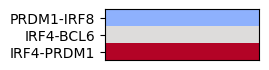

In [16]:
# draw reg heatmap for PB branch (0>1 node IDs); num = points sampled on the traj to draw the heatmap (avg is the same for 100,200 or 300 cells)
import matplotlib.pyplot as plt 
heatmap_pb = d0.draw_regulation_heatmap(
    start=2,
    stop=1,
    regulations=[
        ('PRDM1', 'IRF8'),
        ('IRF4', 'BCL6'),
        ('IRF4', 'PRDM1')
    ],
    num=100
)
plt.show()


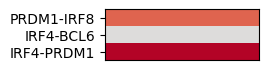

In [17]:
# draw reg heatmap for GC branch (0>1 node IDs); num = points sampled on the traj to draw the heatmap (avg is the same for 100,200 or 300 cells)
import matplotlib.pyplot as plt 
heatmap_gc = d0.draw_regulation_heatmap(
    start=2,
    stop=3,
    regulations=[
        ('PRDM1', 'IRF8'),
        ('IRF4', 'BCL6'),
        ('IRF4', 'PRDM1')
    ],
    num=100
)
plt.show()


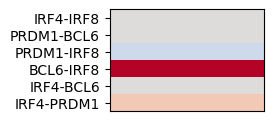

In [18]:
# draw reg heatmap for GC branch (0>1 node IDs); num = points sampled on the traj to draw the heatmap (avg is the same for 100,200 or 300 cells)
import matplotlib.pyplot as plt 
heatmap_abc = d0.draw_regulation_heatmap(
    start=2,
    stop=0,
    regulations=[
        ('IRF4', 'IRF8'),
        ('PRDM1', 'BCL6'),
        ('PRDM1', 'IRF8'),
        ('BCL6', 'IRF8'),
        ('IRF4', 'BCL6'),
        ('IRF4', 'PRDM1')
    ],
    num=100
)
plt.show()


### Animation visualization of dynamic networks

In [2]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
# bifurcation: (S2 > S1) for Plasmo-Blast and (S2 > S3) for Germinal-Center
import matplotlib.pyplot as plt

branches={
	'Plasma-Blast':(0,1),
	'Germinal-Center':(0,3)
}

In [3]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points), use 100 or higher for finer resolution
nframe=10
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100

#### per branch plots

In [4]:
# specify branch specific 
branchname='Plasma-Blast'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['IRF4'],
    ['IRF8']
]
# Select TFs for each row's other plots
tfs_ann=[
	['IRF4', 'IRF8'],
	['PRDM1', 'BCL6'],
]
# Select genes to annotate as targets in all rows
target_ann=['IRF4','IRF8','PRDM1','BCL6']

/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/animation-Plasma-Blast.mp4

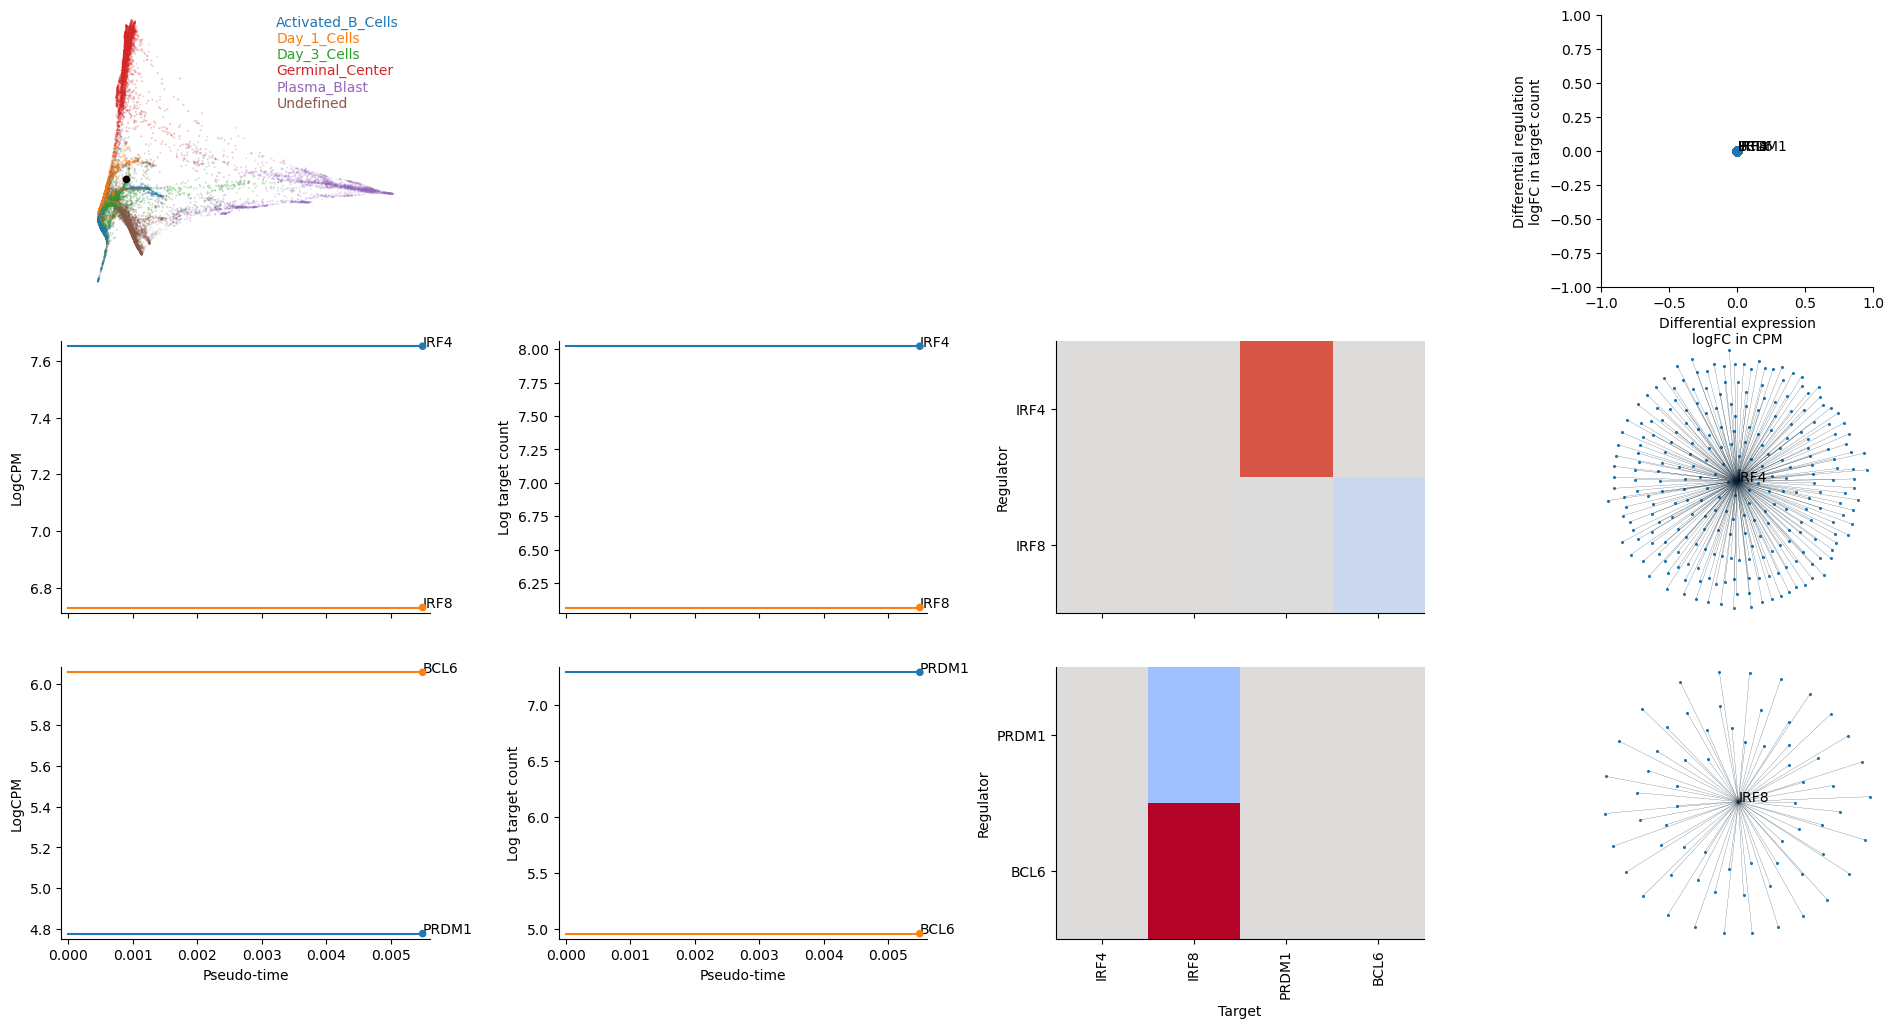

In [6]:
import matplotlib
branch=branches[branchname]
# Draw dynamic network with notch layout
layout1=layout.notch(nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	d0,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)

# Saving animation
# Option 1: Visualize animation within jupyter. This will make the notebook large especially with many frames
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='h264')
w.frame_format='jpeg'
fo=f'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/animation-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))